#### Load documents with ID

In [1]:
import requests
import pandas as pd
import json
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)

documents = docs_response.json()

In [3]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [4]:
with open('document_with_ids.json', 'r') as f:
    data = json.load(f)
data[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

#### Load Ground truth data

In [5]:
df_ground_truth = pd.read_csv('ground_truth_data.csv')
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient= 'records')

In [6]:
ground_truth[10]

{'question': 'What happens if I cannot attend a class session?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [7]:
docs_idx = {d['id']: d for d in documents}
docs_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### index data

In [8]:
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [10]:
es_client = Elasticsearch('http://localhost:9200')

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"
es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index = index_name, body = index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [11]:
from tqdm import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index= index_name, document= doc)

100%|████████████████████████████████████████████████████████████████████████████████| 948/948 [01:01<00:00, 15.48it/s]


In [12]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field" : field,
        "query_vector" : vector,
        "k" : 5,
        "num_candidates" : 10000,
        "filter" : {
            "term" : {
                "course" : course
                }
            }
        }
    search_query = {
        "knn" : knn,
        "_source" : ["text", "section", "question", "course", "id"]
    }
    
    es_result = es_client.search(
        index = index_name,
        body = search_query
    )
    result_docs = []
    
    for hit in es_result['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

def question_text_vector_knn(q):
    question = q["question"]
    course = q["course"]

    v_q = model.encode(question)
    return elastic_search_knn("question_text_vector", v_q, course)

In [13]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

#### The Rag Flow

In [14]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}""".strip()
    context = ""
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nAnswer: {doc['text']}\n\n"

    prompt = prompt_template.format(question=query, context = context).strip()
    return prompt

In [15]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key = api_key)

def llm(prompt, model = 'gpt-4o-mini'):
    response = client.chat.completions.create(
        model = model,
        messages =  [{"role" : "user", "content" : prompt}]
    )
    return response.choices[0].message.content

In [16]:
def rag(query: dict, model = 'gpt-4o-mini') ->str:
    search_results = question_text_vector_knn(query)
    prompt= build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [17]:
ground_truth[10]

{'question': 'What happens if I cannot attend a class session?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [18]:
rag(ground_truth[10])

"If you cannot attend a class session, don't worry, as everything is recorded. You won't miss anything important. You will also have the opportunity to ask questions for office hours in advance, and those questions will be addressed during the live stream. Additionally, you can always pose questions in Slack."

In [19]:
docs_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Cosine Similarity Metric

In [20]:
llm_answer = 'If you cannot attend a class session, everything is recorded, so you won’t miss anything. You can ask your questions in advance for office hours, and those will be covered during the live stream. Additionally, you can always ask questions in Slack.'
doc_answer = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(llm_answer)
v_doc = model.encode(doc_answer)

v_llm.dot(v_doc)

np.float32(0.7919637)

In [33]:
answers = {}

In [34]:
answers

{}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    answer_llm = rag(rec)
    doc_id = rec['document']
    orig_document = docs_idx[doc_id]
    answer_orig = orig_document['text']

    answers[i] = {
        "answer_llm" : answer_llm,
        "answer_orig" : answer_orig,
        "document" : doc_id
    }

In [36]:
df_gpt_4o_mini = pd.DataFrame(answers.values())

In [ ]:
df_gpt_4o_mini

### adding and updating the data to include question
- saving cost: cropped it to 250  
download from zoomcamp repo


In [41]:
#results_gpt4o_mini = [None]*len(ground_truth) 
updated_results_gpt_4o_mini = [None]*len(ground_truth[:250]) 

for i, val in answers.items():
    updated_results_gpt_4o_mini[i] = val.copy()
    updated_results_gpt_4o_mini[i].update(ground_truth[i])

In [117]:
df_updated_results_gpt_4o_mini = pd.DataFrame(updated_results_gpt_4o_mini)
df_updated_results_gpt_4o_mini.to_csv('data/updated_results_gpt_4o_mini_sample_250.csv')

In [21]:
base_url = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main'
relative_url = '04-monitoring/data/results-gpt4o.csv'
docs_url = f'{base_url}/{relative_url}'

df_gpt4o = pd.read_csv(docs_url)

In [22]:
#!mkdir data

In [23]:
rag(ground_truth[10], model='gpt-4o')

'If you cannot attend a class session, everything is recorded, so you won’t miss anything. You can ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack.'

### Comparing gpt-4o with gpt-4o-mini results with similarity metric

In [24]:
llm_4o_mini_answer = 'If you cannot attend a class session, everything is recorded, so you won’t miss anything. You can ask your questions in advance for office hours, and those will be covered during the live stream. Additionally, you can always ask questions in Slack.'
llm_4o_answer = "If you cannot attend a class session, you won't miss anything important because everything is recorded. You will have the opportunity to watch the recordings later. Additionally, you can submit your questions for the office hours in advance, and they will be addressed during the live stream. You can also ask questions anytime in Slack."
v_llm_4o_mini = model.encode(llm_4o_mini_answer)
v_llm_4o = model.encode(llm_4o_answer)

v_llm_4o_mini.dot(v_llm_4o)

np.float32(0.9558694)

#### Multi-threading execution

In [25]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=2)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [26]:
def process_record(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model)

    doc_id = rec['document']
    original_doc = docs_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        "answer_llm" : answer_llm,
        "answer_orig" : answer_orig,
        "document" : doc_id,
        "question" : rec["question"],
        "course" : rec["course"]
    }

In [27]:
process_record(ground_truth[10])

{'answer_llm': 'If you cannot attend a class session, everything is recorded, so you won’t miss anything. You will have the opportunity to ask your questions for office hours in advance, and those questions will be covered during the live stream. Additionally, you can always ask questions in Slack.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'What happens if I cannot attend a class session?',
 'course': 'machine-learning-zoomcamp'}

In [57]:
#resutls_model = map_progress(pool, ground_truth, process_record)

In [28]:
base_url = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main'
relative_url = '04-monitoring/data/results-gpt35.csv'
docs_url = f'{base_url}/{relative_url}'

df_gpt_35 = pd.read_csv(docs_url)

##### Cosine Similarity

### gpt-4o

In [29]:
results_gpt_4o = df_gpt4o.to_dict(orient='records')

In [30]:
record = results_gpt_4o[0]
record

{'answer_llm': 'The CONTEXT provided does not give specific instructions on how to sign up for the course. However, it does mention that you can access the course materials on the course page: [ML Zoomcamp](http://mlzoomcamp.com/). \n\nYou might want to start by visiting the course website and looking for further instructions there, as it likely has additional details on how to sign up or enroll in the course.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [31]:
def compute_similarity(record):
    llm_answer = record['answer_llm']
    doc_answer = record['answer_orig']
    v_llm = model.encode(llm_answer)
    v_doc = model.encode(doc_answer)
    
    return v_llm.dot(v_doc)

In [32]:
similarity = []

for record in tqdm(results_gpt_4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:54<00:00, 10.46it/s]


In [33]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

/tmp/ipykernel_15856/2967343473.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

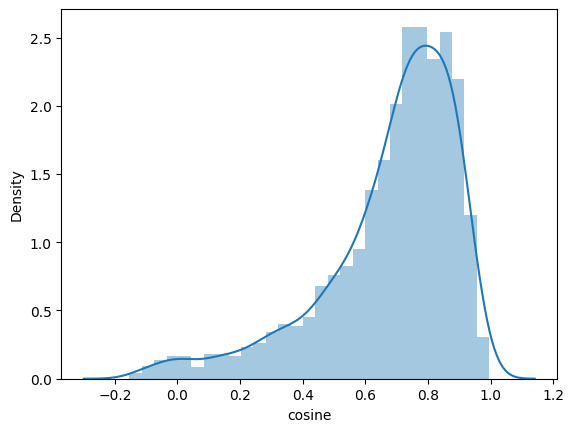

In [34]:
sns.distplot(df_gpt4o['cosine'])

#### gpt-3.5-turbo

In [35]:
results_gpt_35 = df_gpt_35.to_dict(orient='records')

similarity_3_5 = []

for record in tqdm(results_gpt_35):
    sim = compute_similarity(record)
    similarity_3_5.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:15<00:00, 13.50it/s]


In [36]:
df_gpt_35['cosine'] = similarity_3_5
df_gpt_35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

/tmp/ipykernel_15856/1261886430.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label = '4o')
/tmp/ipykernel_15856/1261886430.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt_35['cosine'], label = '3.5')


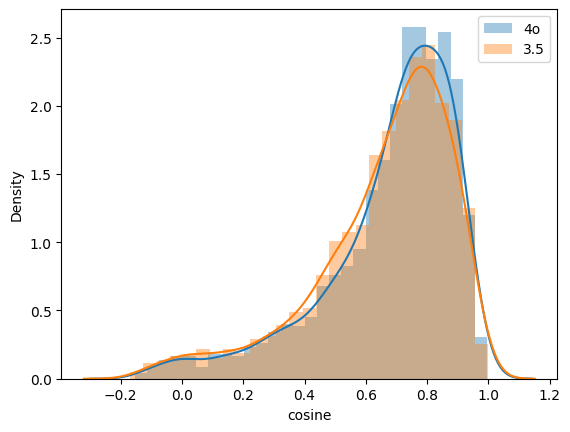

In [37]:
sns.distplot(df_gpt4o['cosine'], label = '4o')
sns.distplot(df_gpt_35['cosine'], label = '3.5')

plt.legend()

### gpt-4o-mini

In [38]:
base_url = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main'
relative_url = '04-monitoring/data/results-gpt4o-mini.csv'
docs_url = f'{base_url}/{relative_url}'

df_gpt_4o_mini = pd.read_csv(docs_url)

results_gpt_4o_mini = df_gpt_4o_mini.to_dict(orient='records')

similarity_4o_mini = []

for record in tqdm(results_gpt_4o_mini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:31<00:00, 12.04it/s]


In [44]:
df_gpt_4o_mini

,answer_llm,answer_orig,document,question,course,cosine
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.388595
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.298360
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.583048
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,-0.019481
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.358467
...,...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp,0.620892
1826,It is best advised that you do not list the Ma...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp,0.730319
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp,0.679815
1828,The advice on including a project link in a CV...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp,0.355928


In [39]:
df_gpt_4o_mini['cosine'] = similarity_4o_mini
df_gpt_4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

```
gpt-4o-mini

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

/tmp/ipykernel_15856/566471859.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label = '4o')
/tmp/ipykernel_15856/566471859.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt_4o_mini['cosine'], label = '4o_mini')
/tmp/ipykernel_15856/566471859.py:3: UserWarning: 


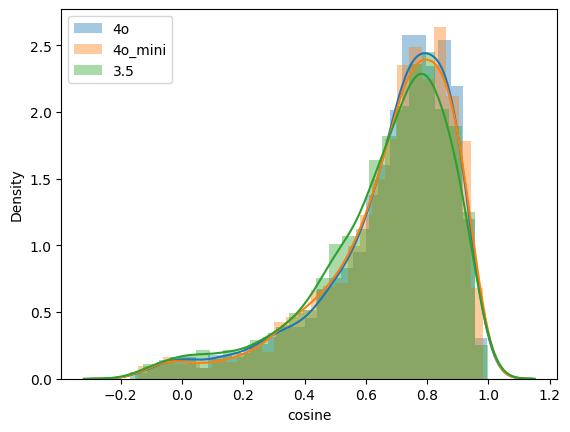

In [43]:
sns.distplot(df_gpt4o['cosine'], label = '4o')
sns.distplot(df_gpt_4o_mini['cosine'], label = '4o_mini')
sns.distplot(df_gpt_35['cosine'], label = '3.5')

plt.legend()

### LLM as A Judge

In [54]:
prompt_template_1 = prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt_template_2 = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

##### sample data

In [55]:
df_sample = df_gpt_4o_mini.sample(n=150, random_state=42)

In [56]:
samples = df_sample.to_dict(orient='records')

In [57]:
record = samples[0]
record

{'answer_llm': "To format a number to 3 decimal places using f-strings, you can use the following syntax:\n\n```python\nprint(f'Average mark for the Homework is {avg:.3f}')\n```\n\nThis will display the value of `avg` rounded to 3 decimal places.",
 'answer_orig': "You can use round() function or f-strings\nround(number, 4)  - this will round number up to 4 decimal places\nprint(f'Average mark for the Homework is {avg:.3f}') - using F string\nAlso there is pandas.Series. round idf you need to round values in the whole Series\nPlease check the documentation\nhttps://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.round.html#pandas.Series.round\nAdded by Olga Rudakova",
 'document': '67afabf5',
 'question': 'Can you demonstrate using f-strings to format a number to 3 decimal places?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.7501978278160095}

In [61]:
prompt = prompt_template_1.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: You can use round() function or f-strings
round(number, 4)  - this will round number up to 4 decimal places
print(f'Average mark for the Homework is {avg:.3f}') - using F string
Also there is pandas.Series. round idf you need to round values in the whole Series
Please check the documentation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.round.html#pandas.Series.round
Added by Olga Rudakova
Generated Question: Can you demonstrate using f-strings to format a number to 3 decimal places?
Generated Answer: To format a number to 3 decimal places using f-strings, you can use the

In [64]:
answer = llm(prompt , model='gpt-4o-mini')

In [65]:
json.loads(answer)

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': 'The generated answer correctly demonstrates the use of f-strings to format a number to 3 decimal places, which directly answers part of the question. However, it omits the mention of the round() function, rounding a number to 4 decimal places, and the information about pandas.Series.round, which were included in the original answer. Therefore, while it is relevant to the specific question, it does not encompass the full breadth of the original answer.'}

In [86]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt_template_1.format(**record)
    answer = llm(prompt , model='gpt-4o-mini')
    evaluations.append(answer)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [03:58<00:00,  1.59s/it]


In [89]:
json.loads(evaluations[130])

{'Relevance': 'NON_RELEVANT',
 'Explanation': 'The generated answer addresses wget issues on MacOS M1 and provides information about installing wget and using curl as an alternative, which is unrelated to the original answer that discusses configuration adjustments for IPv6 addresses. There is no connection between network settings for IPv6 and the use of wget or curl.'}

In [90]:
json_evaluations = []

for i, str_answe in enumerate(tqdm(evaluations)):
    json_answer = json.loads(str_answe)
    json_evaluations.append(json_answer)

100%|████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 142663.40it/s]


In [91]:
df_evaluation_results = pd.DataFrame(json_evaluations)
df_evaluation_results

,Relevance,Explanation
0,PARTLY_RELEVANT,The generated answer specifically addresses th...
1,RELEVANT,The generated answer directly addresses the ge...
2,RELEVANT,The generated answer directly addresses the qu...
3,RELEVANT,The generated answer directly addresses the qu...
4,RELEVANT,The generated answer directly addresses the qu...
...,...,...
145,RELEVANT,The generated answer directly addresses the qu...
146,RELEVANT,The generated answer addresses the question of...
147,RELEVANT,The generated answer accurately explains why t...
148,RELEVANT,The generated answer directly addresses the qu...


In [97]:
df_evaluation_results.Relevance.value_counts()

Relevance
RELEVANT           126
PARTLY_RELEVANT     19
NON_RELEVANT         5
Name: count, dtype: int64

In [108]:
df_evaluation_results[df_evaluation_results.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
49,NON_RELEVANT,The generated answer states that the context d...
98,NON_RELEVANT,The generated answer does not address the orig...
102,NON_RELEVANT,The generated answer does not address the ques...
119,NON_RELEVANT,The generated answer incorrectly states that t...
130,NON_RELEVANT,The generated answer addresses wget issues on ...


In [110]:
samples[102]

{'answer_llm': 'It seems like your question is quite broad; could you please clarify what specific questions you have related to the course? I can provide information based on the FAQ context, such as what happens if you miss a session, project scoring, or how to sign up.',
 'answer_orig': 'While running the docker image if you get the same result check which model you are using.\nRemember you are using a model downloading model + python version so remember to change the model in your file when running your prediction test.\nAdded by Ahmed Okka',
 'document': '9fbfcd61',
 'question': 'questions',
 'course': 'machine-learning-zoomcamp',
 'cosine': -0.03996453434228897}

In [105]:
df_evaluation_results[df_evaluation_results.Relevance == 'NON_RELEVANT'].to_dict(orient='records')

[{'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer states that the context does not provide specific details and refers to the original answer as 'TODO', indicating a lack of content or information to prepare for the assignments. Therefore, it does not address the user's question meaningfully."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer does not address the original question regarding the specific GitHub repository for the course theory. Instead, it provides unrelated advice about creating a personal repository, which does not link back to the original sources provided in the original answer.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer does not address the question about running a Docker image or model usage mentioned in the original answer. Instead, it asks for clarification on a broad question and provides unrelated information about course-related FAQs.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'Th

In [103]:
prompt = prompt_template_2.format(**record)
#print(prompt)

In [96]:
evaluations_2_prompt = []

for record in tqdm(samples):
    prompt = prompt_template_2.format(**record)
    answer = llm(prompt , model='gpt-4o-mini')
    evaluations_2_prompt.append(answer)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [03:47<00:00,  1.52s/it]


In [98]:
json_evaluations_2 = []

for i, str_answe in enumerate(evaluations_2_prompt):
    json_answer = json.loads(str_answe)
    json_evaluations_2.append(json_answer)

In [99]:
df_evaluation_results_2 = pd.DataFrame(json_evaluations_2)
df_evaluation_results_2

,Relevance,Explanation
0,RELEVANT,The generated answer directly addresses the qu...
1,RELEVANT,The generated answer directly addresses the qu...
2,PARTLY_RELEVANT,The generated answer mentions information prov...
3,RELEVANT,The generated answer correctly addresses the q...
4,RELEVANT,The generated answer directly addresses the qu...
...,...,...
145,RELEVANT,The generated answer provides a direct link to...
146,RELEVANT,The generated answer directly addresses the qu...
147,RELEVANT,The generated answer accurately addresses the ...
148,RELEVANT,The generated answer directly addresses the qu...


In [100]:
df_evaluation_results_2.Relevance.value_counts()

Relevance
RELEVANT           128
PARTLY_RELEVANT     21
NON_RELEVANT         1
Name: count, dtype: int64

In [102]:
df_evaluation_results_2[df_evaluation_results_2.Relevance == 'NON_RELEVANT'].to_dict(orient='records')

[{'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer states that there is no specific information available regarding preparation for the coding assignments in Week 8, indicating a lack of relevance to the question asked.'}]

In [106]:
df_evaluation_results_2[df_evaluation_results_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
49,NON_RELEVANT,The generated answer states that there is no s...


In [107]:
samples[49]

{'answer_llm': 'The context does not provide specific details on how to prepare for the coding assignments in Week 8. It simply states "TODO" for the question regarding getting started with Week 8. Therefore, further information or instructions on this preparation are not available in the provided context.',
 'answer_orig': 'TODO',
 'document': 'ff40f83b',
 'question': 'How should I prepare for the coding assignments in Week 8?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.34277015924453735}

In [114]:
df_evaluation_results_2.to_csv('data/df_evaluation_results_2_qa.csv', index=False)

In [115]:
df_evaluation_results.to_csv('data/df_evaluation_results_qa.csv', index=False)

In [116]:
df_gpt_4o_mini.to_csv('data/df_gpt_4o_mini_cosine.csv', index=False)
df_gpt4o.to_csv('data/df_gpt4o_cosine.csv', index=False)
df_gpt_35.to_csv('data/df_gpt_35_cosine.csv', index=False)